## Optimizing a Bounding Chain
OAT's default behavior with bounding chains is to optimize a bounding chain for the initial cycle, not an optimized cycle. Here, we try to figure out how to solve for a bounding chain for an arbitrary (optimized) cycle.

### Preliminaries

In [1]:
# load some packages
import Gavin.utils.make_network as mn
import matplotlib.pyplot as plt
import gurobipy as gb
from time import time
import oatpy as oat
import numpy as np

# config
DATA_PATH = 'datasets/concept_network/'
# CONCEPT_FILE = 'articles_category_for_2l_abstracts_concepts_processed_v1_EX_102.csv.gz' # Applied Mathematics
# CONCEPT_FILE = 'concepts_Applied Economics_1402.csv.gz' # Applied Econ
CONCEPT_FILE = 'concepts_Zoology_608.csv' # Zoology
MIN_RELEVANCE = 0.7
MIN_YEAR = 1920
MIN_FREQ = 0.0006
MAX_FREQ = 0.005

### Setup
Create the graph and solve for the network's homology. This, especially the `factored` object, will be used a lot in the optimization problem.

In [2]:
## Setup the graph
G = mn.gen_concept_network(
        DATA_PATH+CONCEPT_FILE,
        min_relevance=MIN_RELEVANCE,
        min_year=MIN_YEAR,
        min_articles=MIN_FREQ, # 0.006%
        max_articles=MAX_FREQ, # 0.05%
        normalize_year=True
    ) # use a filtered data file
adj = mn.adj_matrix(
        G,
        'norm_year',
        True,
        None
    )

In [3]:
## Solve homology
start = time()
# setup the problem
factored = oat.rust.FactoredBoundaryMatrixVr( # two functions that do this, idk what the other one is
        dissimilarity_matrix=adj,
        homology_dimension_max=2
    )
# solve homology
homology = factored.homology( # solve homology
        return_cycle_representatives=True, # These need to be true to be able to make a barcode, makes the problem take ~30% longer (1:30ish)
        return_bounding_chains=True
    )
f'Homology calculation took {time() - start} secs'

'Homology calculation took 0.6366660594940186 secs'

### Optimize a Cycle
Find the cycle we want to optimize and get an optimal cycle rep for it.

In [38]:
# the cycle we solve for
cycle_i = 529

# optimization problem
start = time()
optimal = factored.optimize_cycle(
        birth_simplex=homology.loc[cycle_i, 'birth simplex'],
        problem_type='preserve PH basis'
    )
print(f'Optimizaiton took {time() - start} secs')

# filter the cycle (only include good coeficicents)
dirty_optimal = optimal.loc['optimal cycle', 'chain'] # round all the dumb and bad coefficicents
dirty_optimal['coefficient'] = dirty_optimal['coefficient'].astype(float) # use floats to interact with gurobi
optimal_cycle = dirty_optimal[np.logical_not(np.isclose(dirty_optimal['coefficient'], 0, atol=0.1))]

# print the cycle
optimal_cycle

Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)
Optimizaiton took 0.06243085861206055 secs

CPU model: Apple M1 Max
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Academic license 2531206 - for non-commercial use only - registered to ge___@macalester.edu
Optimize a model with 1204 rows, 1002 columns and 5922 nonzeros
Model fingerprint: 0xd2c8995d
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-02, 9e-01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 899 rows and 9 columns
Presolve time: 0.00s
Presolved: 305 rows, 993 columns, 3366 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
     253    3.8217822e+00   0.000000e+00   0.000000e+00      0s

Solved in 253 iterations and 0.01 seconds (0.01 work units)
Optimal objective  3.821782178e+00


,simplex,filtration,coefficient
0,"[36, 117]",0.861386,-1.0
1,"[197, 278]",0.801980,-1.0
2,"[36, 56]",0.782178,1.0
3,"[56, 278]",0.702970,1.0
4,"[117, 197]",0.673267,-1.0


### Optimize the Bounding Chain for the Cycle

#### The LP
We'll use an LP to solve the problem. To optimize a $k$ dimensional cycle, we're trying to solve
\begin{align*}
    \min_{\mathbf{x}} \quad & \mathbf{c}^\top | \mathbf{x} | \\
    \text{subject to} \quad & \mathbf{\partial}_d \mathbf{x} = \mathbf{r} \\
\end{align*}
where $\mathbf{c}$ is some vector of weights for the $k+1$ dimensional simplicies that fill in the cycle, $\mathbf{x}$ are the coefficients for the $k+1$ dimensional simplicies marking whether one is included in the bounding chain or not, $\mathbf{\partial}_d$ is the matrix that maps $k+1$ dimensional simplicies to their $k$ dimensional simplex boundry at filtration value $d$, the death time of the cycle (i.e. only simplicies that exist at of before the death of the cycle are included in the problem), and $\mathbf{r}$ is the coefficient values of the cycle, including all 0 coefficients.

#### Needed Values
To solve this LP, we'll need the death time of the cycle, the cycle itself (which we found earlier), the boundary matrix indices, and the boundary matrix.

In [32]:
cycle_dim = 1
death = homology.loc[cycle_i, 'death']
simplex_indicies = factored.indices_boundary_matrix()
boundry_matrix = factored.boundary_matrix().astype(float) # this includes everything, not just k+1 dim to k dim, we'll need to filter later
# scipy likes floats more

#### The Cycle
The optimal cycle doesn't include 0 coefficients. We'll map our cycle coefficients into just the dimension one simplicices in `simplex_indicies` set everything else to 0. This coefficeint column is $\mathbf{r}$ in the LP.

In [33]:
# get relevant simplicies
cycle_rep = simplex_indicies[simplex_indicies['simplex'].str.len() == cycle_dim+1].reset_index() # add 1 bc k dimensional simplicices have k+1 points
# keep index column to use to filter the boundry matrix to the relevant parts later
cycle_rep = cycle_rep[cycle_rep['filtration'] <= death] # only need ones that exist before the death time

# figure out coefficients
cycle_rep = cycle_rep.assign(
        simplex=cycle_rep['simplex'].apply(tuple) # can't merge on lists, convert to tuples first (which is hashable)
    ).merge(
        right=optimal_cycle.assign(
                simplex=optimal_cycle['simplex'].apply(tuple) # same list merge issue
            ),
        on=['simplex', 'filtration'],
        how='left' # keep cycle rep list as is, just with coefificeint column
    ).assign(
        simplex=cycle_rep['simplex'].apply(list) # convert back to list (prolly doesn't need to done done but still)
    ).replace(
        np.nan, 0 # set unmerged columns to 0
    )

cycle_rep

,index,simplex,filtration,coefficient
0,302,"[16, 24]",0.039604,0.0
1,303,"[22, 33]",0.069307,0.0
2,304,"[7, 33]",0.079208,0.0
3,305,"[86, 225]",0.099010,0.0
4,306,"[86, 234]",0.099010,0.0
...,...,...,...,...
1122,1424,"[242, 268]",0.891089,0.0
1123,1425,"[243, 257]",0.891089,0.0
1124,1426,"[254, 299]",0.891089,0.0
1125,1427,"[262, 299]",0.891089,0.0


#### The Chain
the bounding chain is going to be $k+1$ dimensional simplicies that exist before the death time. Keep all of these to know which rows of the boundary matrix to keep and to match to once we solve for the coefficients ($\mathbf{x}$ in our LP). This also gives us our (current, we can choose to use whatever we want) $\mathbf{c}$ in the form of the filtration column.

In [34]:
# get relevant simplicies
bounding_chain = simplex_indicies[simplex_indicies['simplex'].str.len() == cycle_dim+2].reset_index() # add 1 bc k dimensional simplicices have k+1 points
# keep index column to use to filter the boundry matrix to the relevant parts later
bounding_chain = bounding_chain[bounding_chain['filtration'] <= death] # only need ones that exist before the death time

bounding_chain

,index,simplex,filtration
0,3098,"[86, 225, 234]",0.099010
1,3099,"[7, 16, 24]",0.108911
2,3100,"[7, 22, 33]",0.178218
3,3101,"[170, 226, 229]",0.485149
4,3102,"[161, 225, 233]",0.514851
...,...,...,...
1457,4555,"[231, 232, 234]",0.891089
1458,4556,"[231, 297, 298]",0.891089
1459,4557,"[236, 282, 298]",0.891089
1460,4558,"[243, 246, 257]",0.891089


#### The Boundary Matrix
Use the `boundry_matrix` and at the indicies in the `cycle_rep` and `bounding_chain` dataframes to create $\mathbf{\partial}_d$ from the LP. We keep rows corresponding to the `cycle_rep` values (since the rows should map to the cycle coefficients) and the columns from `bounding_chain` (since the columns should each multiply by the bounding chain coefficients).

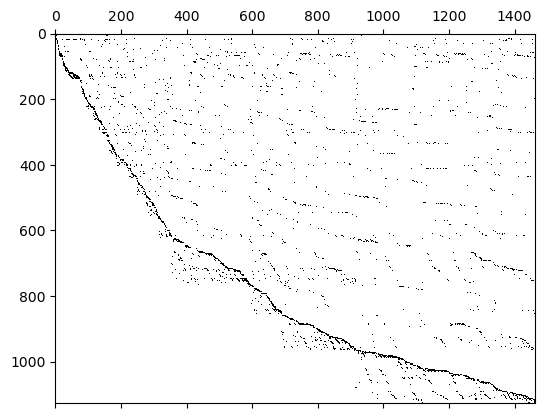

In [35]:
'''
Scipy matricies are werid. Something like 
```
lp_boundry_matrix = boundry_matrix[cycle_rep['index'], bounding_chain['index']]
```
should work, but it doesn't support real indexing without either a slice for the other one or both being the same length

Therfore, you either do something like this
```
# spare matricies are really finicky and don't have great support for index referenceing. therefore, we find slice indicies and use that
cycle_min_i = cycle_rep['index'].min()
cycle_max_i = cycle_rep['index'].max()+1 # upper bound is exclusive
assert (cycle_rep['index'] == np.arange(cycle_min_i, cycle_max_i)).all() # make sure index is a range (so slicing is valid)

bounding_chain_min_i = bounding_chain['index'].min()
bounding_chain_max_i = bounding_chain['index'].max()+1 # upper bound is exclusive
assert (bounding_chain['index'] == np.arange(bounding_chain_min_i, bounding_chain_max_i)).all() # make sure index is a range (so slicing is valid)

# get bounding chain bounds
lp_boundry_matrix = boundry_matrix[cycle_min_i:cycle_max_i, bounding_chain_min_i:bounding_chain_max_i]
```
and use slicing or use the following implentation
'''
lp_boundry_matrix = boundry_matrix[cycle_rep['index'], :][:, bounding_chain['index']]

plt.spy(lp_boundry_matrix, marker=',', c='k')

#### Create the model
Use the `gurobipy` module to create and optimize the model to solve for the bounding chain.

Unfortunately, an LP can't natively handle an absolute value in the objective function. There are a couple ways of dealing with this, two of which are shown here.

The first way uses an extra $\mathbf{y}$ free variable set to $\mathbf{y} = | \mathbf{x} |$ using two additional inequalities (for each value in $\mathbf{x}$). Therefore, the LP becomes
\begin{align*}
    \min_{\mathbf{x}, \mathbf{y}} \quad & \mathbf{c}^\top \mathbf{y} \\
    \text{subject to} \quad & \mathbf{y} \geq \mathbf{x} \\
    & \mathbf{y} \geq -\mathbf{x} \\
    & \mathbf{\partial}_d \mathbf{x} = \mathbf{r} \\
    & \mathbf{x} \in \mathbb{R}^n, \mathbf{y} \geq 0
\end{align*}
The resulting coefficients end up just being the $\mathbf{x}$ vector.

This method is slower than the alternative and, therefore, not preferred. 

In [36]:
# setup the model
m = gb.Model('Optimal Bounding Chain')

# free (decision) variables
coeffs = m.addMVar((len(bounding_chain)), lb=-gb.GRB.INFINITY)
abs_coeffs = m.addMVar((len(bounding_chain)))

# constraints
m.addConstrs((abs_coeffs[i] == gb.abs_(coeffs[i]) for i in range(len(bounding_chain))), name='abs')
m.addConstr(lp_boundry_matrix @ coeffs == np.array(cycle_rep['coefficient']), 'boundry') # idk if pandas works with gurobi, im not thinking about it rn tho

# objective
m.setObjective(gb.quicksum(np.array(bounding_chain['filtration']) * abs_coeffs))

# optimize
m.optimize()

# get solution
bounding_chain['coefficient'] = coeffs.X

# close model
# m.close()

# clean results
optimal_bounding_chain = bounding_chain.loc[bounding_chain['coefficient'] != 0, ['simplex', 'filtration', 'coefficient']].reset_index(drop=True)

optimal_bounding_chain

Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M1 Max
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Academic license 2531206 - for non-commercial use only - registered to ge___@macalester.edu
Optimize a model with 1127 rows, 2924 columns and 4386 nonzeros
Model fingerprint: 0x9f00f01f
Model has 1462 general constraints
Variable types: 2924 continuous, 0 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-01, 9e-01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve added 1984 rows and 0 columns
Presolve removed 0 rows and 472 columns
Presolve time: 0.00s

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 1 (of 10 available processors)

Solution count 0

Model is infeasible
Best objective -, best bound -, gap -


GurobiError: Unable to retrieve attribute 'X'

The other method splits $\mathbf{x}$ into two vectors, $\mathbf{x}^+$ and $\mathbf{x}^-$ such that $\mathbf{x} = \mathbf{x}^+ - \mathbf{x}^-$ and $\mathbf{x}^+, \mathbf{x}^- \geq 0$. In this case, $|\mathbf{x}| = \mathbf{x}^+ + \mathbf{x}^-$, which can be plugged into an LP. This creates the same number of decision variables and a longer objective function, but fewer constraints making it much faster.

This LP is
\begin{align*}
    \min_{\mathbf{x}^+, \mathbf{x}^-} \quad & \mathbf{c}^\top (\mathbf{x}^+ + \mathbf{x}^-) \\
    \text{subject to} \quad & \mathbf{\partial}_d (\mathbf{x}^+ - \mathbf{x}^-) = \mathbf{r} \\
    & \mathbf{x}^+, \mathbf{x}^- \geq 0
\end{align*}

In [24]:
# setup the model
m = gb.Model('Optimal Bounding Chain')

# free (decision) variables
pos_coeffs = m.addMVar((len(bounding_chain)))
neg_coeffs = m.addMVar((len(bounding_chain)))

# constraints
m.addConstr(lp_boundry_matrix @ (pos_coeffs-neg_coeffs) == np.array(cycle_rep['coefficient']), 'boundry') # idk if pandas works with gurobi, im not thinking about it rn tho

# objective
m.setObjective(gb.quicksum(np.array(bounding_chain['filtration']) * (pos_coeffs+neg_coeffs)))

# optimize
m.optimize()

# get solution
bounding_chain['coefficient'] = pos_coeffs.X - neg_coeffs.X

# close model
m.close()

# clean results
optimal_bounding_chain = bounding_chain.loc[bounding_chain['coefficient'] != 0, ['simplex', 'filtration', 'coefficient']].reset_index(drop=True)

optimal_bounding_chain

Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M1 Max


Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Academic license 2531206 - for non-commercial use only - registered to ge___@macalester.edu
Optimize a model with 1127 rows, 2924 columns and 8772 nonzeros
Model fingerprint: 0xeac3f3c6
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-01, 9e-01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 733 rows and 632 columns
Presolve time: 0.01s
Presolved: 394 rows, 2292 columns, 5646 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.8316832e+00   7.000000e+00   0.000000e+00      0s
Extra simplex iterations after uncrush: 22
      34    1.4653465e+01   0.000000e+00   0.000000e+00      0s

Solved in 34 iterations and 0.01 seconds (0.01 work units)
Optimal objective  1.465346535e+01


,simplex,filtration,coefficient
0,"[95, 202, 243]",0.772277,1.0
1,"[95, 202, 245]",0.811881,-1.0
2,"[146, 151, 260]",0.831683,1.0
3,"[56, 278, 282]",0.851485,1.0
4,"[36, 56, 282]",0.861386,1.0
5,"[36, 245, 282]",0.861386,-1.0
6,"[146, 260, 282]",0.861386,1.0
7,"[245, 260, 282]",0.861386,-1.0
8,"[202, 243, 294]",0.871287,-1.0
9,"[202, 245, 294]",0.871287,1.0


### OAT Optimization
This mainly serves to be able to compare times, not results, since OAT solves a very different problem.

In [11]:
# optimization problem
start = time()
optimal = factored.optimize_bounding_chain(
        birth_simplex=homology.loc[cycle_i, 'birth simplex']
    )
print(f'Optimizaiton took {time() - start} secs')

# filter the cycle (only include good coeficicents)
dirty_optimal = optimal.loc['optimal bounding chain', 'chain'] # round all the dumb and bad coefficicents
dirty_optimal['coefficient'] = dirty_optimal['coefficient'].astype(float) # use floats to interact with gurobi
non_optimal_bounding_chain = dirty_optimal[np.logical_not(np.isclose(dirty_optimal['coefficient'], 0, atol=0.1))]

# print the cycle
non_optimal_bounding_chain

Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)
Optimizaiton took 1.2481520175933838 secs

CPU model: Apple M1 Max
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Academic license 2531206 - for non-commercial use only - registered to ge___@macalester.edu
Optimize a model with 14408 rows, 12409 columns and 214050 nonzeros
Model fingerprint: 0xf9b4310e
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [1e-01, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 9671 rows and 2 columns
Presolve time: 0.06s
Presolved: 4737 rows, 12407 columns, 115476 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.04s

Barrier statistics:
 Dense cols : 12
 Free vars  : 2740
 AA' NZ     : 2.409e+05
 Factor NZ  : 5.647e+05 (roughly 12 MB of memory)
 Factor Ops : 1.873e+08 (less than 1 second per iterati

,simplex,filtration,coefficient
0,"[177, 187, 267]",0.990099,1.0
1,"[100, 177, 187]",0.990099,-1.0
2,"[99, 187, 267]",0.940594,-1.0
3,"[176, 177, 204]",0.772277,1.0
4,"[100, 176, 177]",0.772277,-1.0


### Questions:
Is it possible to optimize a cycle into having a different death time?

Index 529